In [2]:
import time
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By


chrome_options = Options()

# MANDATORY FOR LINUX/SERVER ENVIRONMENTS
# chrome_options.add_argument("--headless=new") # Run without a UI
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
chrome_options.add_argument("--disable-gpu")

# Optional: Pretend to be a real browser to avoid blocks
chrome_options.add_argument("user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36")


service = Service()
driver = webdriver.Chrome(service=service, options=chrome_options)

driver.get("https://finance.yahoo.com/quote/TSLA/earnings/TSLA-Q4-2025-earnings_call-393464.html")
time.sleep(10) # Wait for JS to render


In [3]:
driver.find_element(By.XPATH, "/html/body/div/div/div/div/form/div[2]/div[2]/button[1]").click()

In [4]:
messages=driver.find_element(By.CLASS_NAME, "yf-1f6rbxb")

In [7]:
messages=element = driver.find_element(By.CSS_SELECTOR, ".items.yf-1f6rbxb")

In [8]:
import pandas as pd
import re

messages_list = messages.text.split("\n")

rows = []

time_re = re.compile(r"^\d{1,2}:\d{2}:\d{2}$")
lines = [line.strip() for line in messages_list if line.strip()]

i = 0
while i < len(lines):
    if i + 2 < len(lines) and time_re.match(lines[i + 2]):
        person = lines[i]
        time = lines[i + 2]
        text = lines[i + 3] if i + 3 < len(lines) else ""
        rows.append({"text": text, "person": person, "time": time})
        i += 4
    elif i + 1 < len(lines) and time_re.match(lines[i + 1]):
        person = lines[i]
        time = lines[i + 1]
        text = lines[i + 2] if i + 2 < len(lines) else ""
        rows.append({"text": text, "person": person, "time": time})
        i += 3
    else:
        i += 1

df_messages = pd.DataFrame(rows, columns=["text", "person", "time"])
df_messages

,text,person,time
0,"Good afternoon, everyone, and welcome to Tesla...",Travis Axelrod,0:00:00
1,"Before we jump into Q&A, Elon has some opening...",Ashok Elluswamy,0:00:50
2,"Thanks, Travis. So, we've updated the Tesla mi...",Elon Musk,0:00:54
3,"And obviously, along that way, we're going to ...",Ashok Elluswamy,0:01:48
4,And we're seeing obviously the first steps alo...,Ashok Elluswamy,0:02:30
...,...,...,...
117,It's not the first time you asked.,Lars Moravy,1:00:59
118,"Exactly. I mean, this is not the first time yo...",Vaibhav Taneja,1:01:00
119,"Like, why do we have to build these things? Wh...",Elon Musk,1:01:04
120,"Great. Unfortunately, that's all the time we h...",Travis Axelrod,1:01:47


In [9]:
import torch
# Check if CUDA (GPU support) is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_id="cardiffnlp/twitter-roberta-base-sentiment-latest"

# Allow download if not cached locally

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)


def get_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    # Move input tensors to the same device as the model
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    sentiment = torch.argmax(probs, dim=1).item()
    # 0: negative, 1: positive
    return  probs

Using device: cuda


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_messages['sentiment'] = df_messages['text'].apply(get_sentiment)

# Extract the three sentiment probabilities into separate columns
df_messages['negative'] = df_messages['sentiment'].apply(lambda x: float(x[0][0].cpu().numpy()))
df_messages['neutral'] = df_messages['sentiment'].apply(lambda x: float(x[0][1].cpu().numpy()))
df_messages['positive'] = df_messages['sentiment'].apply(lambda x: float(x[0][2].cpu().numpy()))



,text,person,time,sentiment,sentiment_score,sentiment_label,negative,neutral,positive
0,"Good afternoon, everyone, and welcome to Tesla...",Travis Axelrod,0:00:00,"[[tensor(0.0035, device='cuda:0'), tensor(0.24...",0.249,positive,0.003509,0.249023,0.747468
1,"Before we jump into Q&A, Elon has some opening...",Ashok Elluswamy,0:00:50,"[[tensor(0.0041, device='cuda:0'), tensor(0.90...",0.908,positive,0.004074,0.908249,0.087677
2,"Thanks, Travis. So, we've updated the Tesla mi...",Elon Musk,0:00:54,"[[tensor(0.0025, device='cuda:0'), tensor(0.03...",0.032,positive,0.002460,0.031593,0.965948
3,"And obviously, along that way, we're going to ...",Ashok Elluswamy,0:01:48,"[[tensor(0.0173, device='cuda:0'), tensor(0.16...",0.169,positive,0.017343,0.169177,0.813479
4,And we're seeing obviously the first steps alo...,Ashok Elluswamy,0:02:30,"[[tensor(0.0054, device='cuda:0'), tensor(0.10...",0.106,positive,0.005404,0.105999,0.888597
...,...,...,...,...,...,...,...,...,...
117,It's not the first time you asked.,Lars Moravy,1:00:59,"[[tensor(0.2241, device='cuda:0'), tensor(0.72...",0.728,positive,0.224067,0.728183,0.047750
118,"Exactly. I mean, this is not the first time yo...",Vaibhav Taneja,1:01:00,"[[tensor(0.5415, device='cuda:0'), tensor(0.42...",0.429,negative,0.541547,0.428669,0.029784
119,"Like, why do we have to build these things? Wh...",Elon Musk,1:01:04,"[[tensor(0.4412, device='cuda:0'), tensor(0.46...",0.463,positive,0.441182,0.463262,0.095557
120,"Great. Unfortunately, that's all the time we h...",Travis Axelrod,1:01:47,"[[tensor(0.0076, device='cuda:0'), tensor(0.04...",0.042,positive,0.007563,0.041991,0.950446


<Axes: >

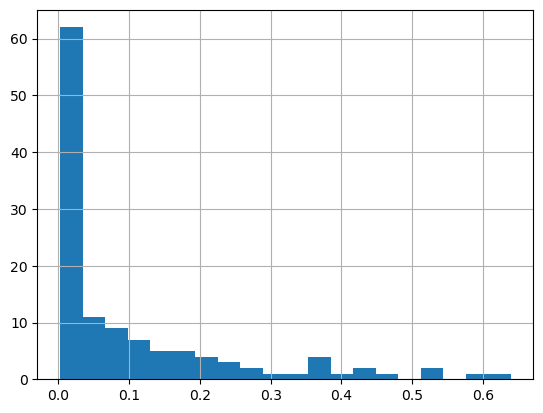

In [ ]:
df_messages['negative'].hist(bins=20)

<Axes: >

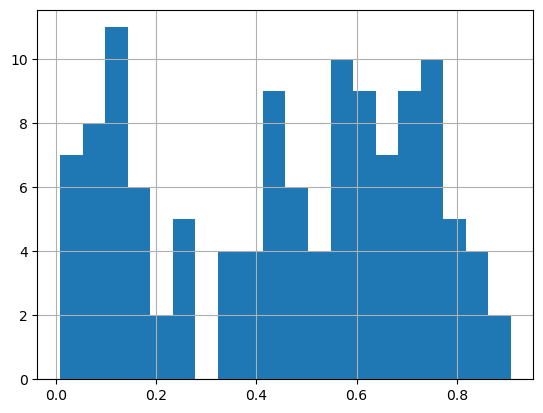

In [18]:
df_messages['neutral'].hist(bins=20)

<Axes: >

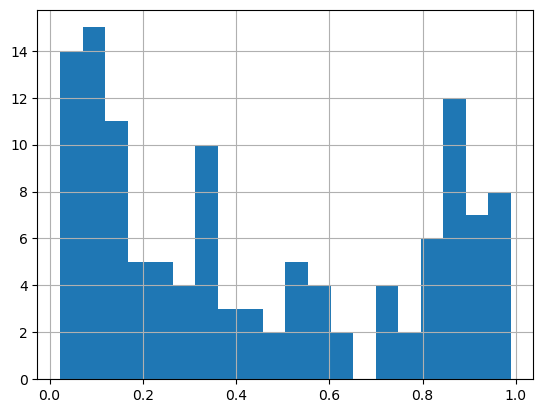

In [17]:
df_messages['positive'].hist(bins=20)